In [1]:
import pygeostat as gs
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#TensorFLow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, concatenate
from tensorflow.keras.layers import LSTM, SimpleRNN, Dropout, GRU, Conv2D, MaxPool2D
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, Nadam, SGD
from tensorflow import keras

<h1 style='color:#1B127A;'>
Introduction
</h1>

In general, slope of regression is related to a linear regression model and determines the change in response with 1 unit change in an independent variable (i.e. a feature). In a cross validation plot, that is a scatter plot between the estimate and truth, the slope of regression may be calculated between the response variable (data) and the estimator's response. It is often used to check conditional bias for a linear estimator like simple/ordinary kriging. 

It should be noted that in the cross validation step, a linear model is fitted between the observations of the response variable and the corresponding estimated ones. In kriging, the response variable is a missing data location while the features are some nearby data locations. Thus, there are no multiple observations of different variable to fit a regression model based on minimizing the squared error. Instead, each data location and the unsampled on are treated as random variables and the expected squared error is minimized which results in kriging equations that is very similar to multiple linear regression. It an be said that kriging is equivalent to solving multiple linear regression at each unsampled location using stationary covariance/variogram function. In this context, kriging is expected to have a slope of regression that is close to 1 to avoid conditional bias.

In this notebook, it is shown that a linear regression estimator will always have a slope of regression equal to 1 on the cross validation side. This is true by definition. It can be shown that the covariance between the linear estimator and the response variable is equal to the variance of the estimator. The slope of regression is $C_{XY}/C_{XX}$ where $X$ is the feature and $Y$ is the response variable. 

$COV(Z_0,\sum \lambda_{\alpha}Z_{\alpha}) = \sum \lambda_{\alpha} C(0,\alpha)$  that is the variance of the estimator.

Thus, in theory, simple kriging is proved to have a slope of regression equal to 1 similar to a multiple linear regression model.

Also, that in order to minimize the squared error, the estimator response surface has to be as close as possible to mean of the conditional distributions. Because for each conditioning data set with multiple observations of the response variable, the answer that minimizes the squared error is the mean. Thus, any estimator needs to minimize deviation for the conditional means. 

It is shown in this notebook that for a non-linear case, a non-linear estimator (MLP ANN) will provide a superior response compared to a linear estimator and has a slope of regression equal to 1 at the cross validation step. This is because, the non-linear estimate passes through the conditional means. Thus, at the cross validation plot, all the conditional means are equal (very close) to the estimated value. So, the conditional means sit on 45 degree line and the fitted linear model between the non-linear estimate and its response variable will have a slope of 1.

<h1 style='color:#1B127A;'>
Settings
</h1>

In [3]:
gs.Parameters['data.nreal'] = 1
gs.Parameters['plotting.sigfigs'] = 2
gs.Parameters['plotting.scatter_plot.stat_xy'] = (0.9,0.95)
gs.Parameters['plotting.scatter_plot.s'] = 10
gs.PlotStyle['figure.figsize'] = (10, 10)

<h1 style='color:#1B127A;'>
Helper functions
</h1>

In [4]:
class mlr(object):
    
    '''
    A simple implementation of multiple linear regression
    
    X: array of n by d where n is the number of observation and d is the number of dimensions/features
    Y: array of n by 1 where n is the number of observation
    '''
    
    
    def __init__(self):
        self.weights = []
        
        
    def fit(self, X, y):
        
        if len(X.shape) == 1:
            X = self._reshape_x(X)
            
        X = self._concatenate_ones(X)
        self.weights = np.linalg.inv(X.transpose().dot(X)).dot(X.transpose().dot(y))
        
    def predict(self, feature_set):
        b = self.weights[0]
        w = self.weights[1:]
        
        prediction = feature_set.dot(w) + b
        
        return prediction
    
    def _reshape_x(self, X):
        return X.reshape(-1,1)
    
    def _concatenate_ones(self,X):
        ones = np.ones(shape=X.shape[0]).reshape(-1,1)
        return np.concatenate((ones,X), 1)

In [5]:
def plot_model_results(history, ax= None, loss_dict=None):
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize= (8,5))
    
    if loss_dict is None:
        loss_dict = {'loss':'loss', 'val_loss':'val_loss'}
        
    ax.plot(history.history[loss_dict['loss']], label='Training Loss', c='r')
    try:
        ax.plot(history.history[loss_dict['val_loss']], label='Validation Loss', c='blue')
    except:
        pass
    ax.grid()
    ax.legend(fontsize=14)
    
class Config():
    '''
    A class for configuration of CNN
    '''
    def __init__(self, batch_size, n_epochs, min_delta, stop_patience, lr_patience=None, rnn_nodes = None, repeated_predictions=False, monitor ='loss'):    
        self.repeated_predictions = repeated_predictions
        self.batch_size = batch_size
        self.rnn_nodes = rnn_nodes
        self.n_epochs = n_epochs
        
        # Early stop call back for keras
        self.early_stop_clbk = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                                min_delta=min_delta, 
                                                                patience=stop_patience,
                                                                verbose=0, 
                                                                mode='auto',
                                                                restore_best_weights=True)
        if lr_patience is not None:
            # Adaptive learning rate call back for keras
            self.lr_plan = ReduceLROnPlateau(monitor='val_loss',
                                             factor=0.1,patience=lr_patience,
                                             verbose=0,
                                             mode='auto',
                                             min_delta=min_delta)

<h1 style='color:#1B127A;'>
  Bivariate case study
</h1>

<h2 style='color:#5177F9;'>
Linear Bivariate
</h2>

A bivariate Gaussian distribution is sampled since we know that all the conditional means sit on a line and the slope of that line is given by the covariance and variance (covariance matrix) using normal equations.

<h3 style='color:#51AFF9;'>
Sample data
</h3>

In [6]:
n_sample = 5000
mean = np.array([0, 0])
cov = np.array([[2, 0.8], [0.8, 1]])  # diagonal covariance
cov_inv = np.linalg.inv(cov)
n_mv_samples = np.random.multivariate_normal(mean, cov, n_sample).T

data=pd.DataFrame(dtype=np.float32)
variables = []
for i, variable in enumerate(n_mv_samples):
    var_name = 'Variable%i'%(i+1)
    variables.append(var_name)
    data[var_name] = variable

data.head()

,Variable1,Variable2
0,-2.412145,1.022454
1,-1.590798,-1.082074
2,0.602077,0.215180
3,-0.253566,0.300824
4,1.681254,1.627174


<h3 style='color:#51AFF9;'>
Bivariate scatter plot
</h3>

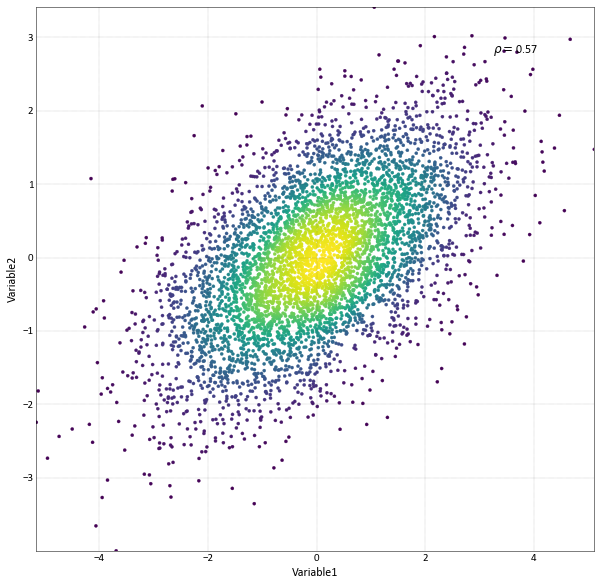

In [7]:
 _ = gs.scatter_plot(data[variables[0]],data[variables[1]], grid=True,rasterized=True)

<h3 style='color:#51AFF9;'>
Fitting a linear regression model
</h3>

In [8]:
X = data.Variable1.values.reshape(-1,1)
y = data.Variable2.values.reshape(-1,1)

In [9]:
model = mlr() 
model.fit(X,y)

<h3 style='color:#51AFF9;'>
Scatter plot and cross validation for the estimate
</h3>
As can be seen below, the slope of regression for cross-validation is 1 as expected for a linear regression.

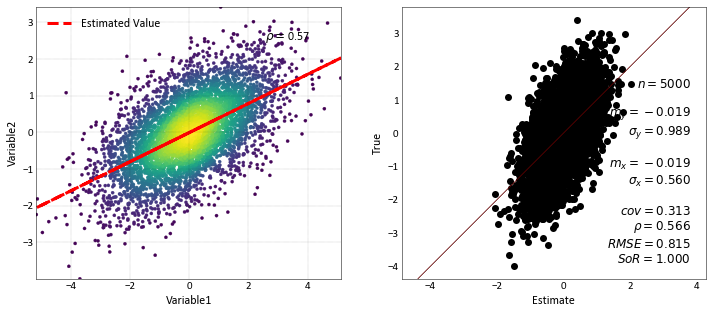

In [10]:
fig, axes = plt.subplots(1,2, figsize= (12,5))

ax=axes[0]
gs.scatter_plot(X.flatten(),y.flatten(), grid=True,rasterized=True, figsize=(6,6),
                     xlabel='Variable1', ylabel='Variable2', ax=ax)
ax.plot(X, model.predict(X), c='r', ls = '--', lw=3, label='Estimated Value')
ax.legend(fontsize=12)

ax=axes[1]
gs.validation_plot(model.predict(X).flatten(), y.flatten(), ax=ax)

<h2 style='color:#5177F9;'>
Bivariate with non-linear relationship
</h2>

A non-linear case is created to show that we can fit a linear model and show that at the cross validation level it has a slope of regression equal to 1. This is mainly because the slope of regression is all about fitting a linear model. Also, we can shows that a non linear estimator can provide superior result with slope of regression being equal to 1. 

<h3 style='color:#51AFF9;'>
Sample Data
</h3>

In [11]:
x = np.linspace(0,1,5000)
y = 3*(np.sin(2*x) + np.random.normal(loc=0.0, scale=0.1, size=len(x)))

data=pd.DataFrame(dtype=np.float32)
variables = []
for i, variable in enumerate([x,y]):
    var_name = 'Variable%i'%(i+1)
    variables.append(var_name)
    data[var_name] = variable

data.head()

,Variable1,Variable2
0,0.0000,-0.343961
1,0.0002,0.497727
2,0.0004,0.147171
3,0.0006,0.110476
4,0.0008,0.240819


<h3 style='color:#51AFF9;'>
Bivariate scatter plot
</h3>

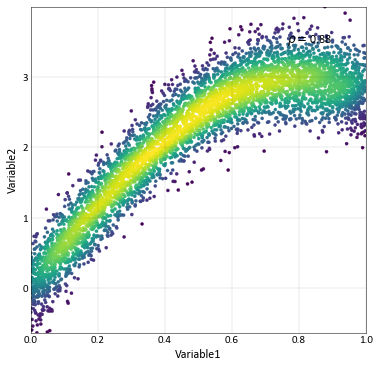

In [12]:
_ = gs.scatter_plot(data[variables[0]], data[variables[1]], grid=True,rasterized=True, figsize=(6,6))

<h3 style='color:#51AFF9;'>
 Scatter plot and cross validation for the estimate 
</h3>

As can be seen below, the linear model fails to capture the non linear trend. However, it is designed to minimize the over all deviation from all the conditional means (mean of variable 2 conditional to variable 1 at different values of variable 1 that is the conditioning variable). The slope of regression on the cross validation is still 1 which is expected as was discussed above.

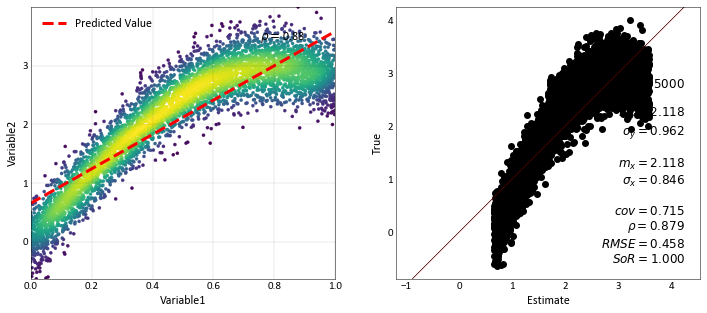

In [13]:
X = data.Variable1.values.reshape(-1,1)
y = data.Variable2.values.reshape(-1,1)
model = mlr() 
model.fit(X,y)
fig, axes = plt.subplots(1,2, figsize= (12,5))

ax=axes[0]
gs.scatter_plot(X.flatten(),y.flatten(), grid=True,rasterized=True, figsize=(6,6),
                     xlabel='Variable1', ylabel='Variable2', ax=ax)
ax.plot(X, model.predict(X), c='r', ls = '--', lw=3, label='Predicted Value')
ax.legend(fontsize=12)

ax=axes[1]
gs.validation_plot(model.predict(X).flatten(), y.flatten(), ax=ax)

<h3 style='color:#51AFF9;'>
MLP ANN
</h3>

Design a multi layer perceptron neural net to fit the non linear model.

In [14]:
# Creat the model
mlp_model = Sequential(name='MlpSequential2')



mlp_model.add(Dense(128, activation='sigmoid',
                kernel_initializer='glorot_normal',
                input_shape=(1,),
                name='layer1'))

mlp_model.add(Dense(64, activation='sigmoid',
                kernel_initializer='glorot_normal',
                input_shape=(1,),
                name='layer2'))

mlp_model.add(Dense(16, activation='sigmoid',
                kernel_initializer='glorot_normal',
                input_shape=(1,),
                name='layer3'))

mlp_model.add(Dense(1, activation='linear',
                kernel_initializer='glorot_normal',
                input_shape=(1,),
                name='output'))

mlp_model.compile(loss='mse', 
              optimizer=Nadam(learning_rate=0.01), 
              metrics=[tf.keras.metrics.mean_squared_error])

mlp_model.summary()

Model: "MlpSequential2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 128)               256       
_________________________________________________________________
layer2 (Dense)               (None, 64)                8256      
_________________________________________________________________
layer3 (Dense)               (None, 16)                1040      
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 9,569
Trainable params: 9,569
Non-trainable params: 0
_________________________________________________________________


In [15]:
features = variables[:-1]

train_X = data[features].values

labels = [variables[-1]]

train_y = data[labels].values.reshape(len(data))

In [16]:
config = Config(batch_size=len(train_X), n_epochs = 1000, min_delta=0.001, stop_patience=200, lr_patience=50)

In [17]:
history = mlp_model.fit(train_X, train_y, epochs=config.n_epochs, 
                    batch_size=config.batch_size,
                    callbacks=[config.early_stop_clbk],
                    verbose=0
                   )

In [18]:
prediction_train = mlp_model.predict(train_X).reshape(len(train_X))

<h3 style='color:#51AFF9;'>
Scatter plot and cross validation for the non-linear model
</h3>

As can be seen below, the non-linear estimator can pass through conditional means and further reduce the overall squared error. Also, the cross validation scatter plot shows that the slope of regression is 1 because all the estimated values are very close to the conditional mean thus they all sit on the 45 degree line. Note that the non-linear trend is filtered out at the cross validation plot that is a scatter plot between the non-linear estimator and the response variable.

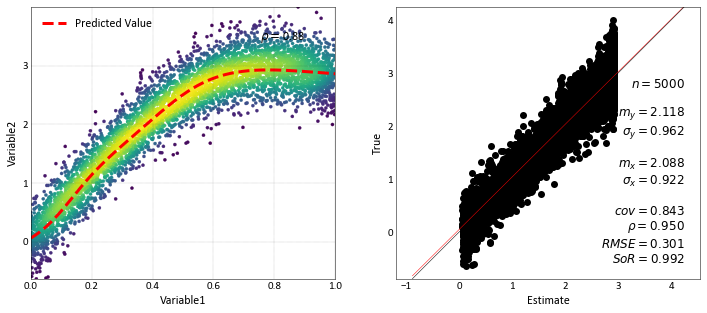

In [19]:
fig, axes = plt.subplots(1,2, figsize= (12,5))

ax=axes[0]
gs.scatter_plot(train_X.flatten(),train_y, grid=True,rasterized=True, figsize=(6,6),
                     xlabel='Variable1', ylabel='Variable2', ax=ax)
ax.plot(train_X.flatten(), prediction_train, c='r', ls = '--', lw=3, label='Predicted Value')
ax.legend(fontsize=12)

ax=axes[1]
gs.validation_plot(prediction_train, train_y, ax=ax)